We're interested in the following ligand binding scheme:

$M + nL \stackrel{K_1}{\rightleftharpoons} LM + (n - 1)L \stackrel{K_2}{\rightleftharpoons} ... 
\stackrel{K_{n-1}}{\rightleftharpoons} L_{n-1}M + L \stackrel{K_n}{\rightleftharpoons} L_nM$

where the $K_i$'s are macroscopic dissociation constants. All association/dissociation constants below are macroscopic.

To simulate [ITC](https://en.wikipedia.org/wiki/Isothermal_titration_calorimetry) experiments, we will also consider enthalpy changes $\Delta H_i$. This refers to the enthalpy change between $L_{i-1}M$ and $L_iM$, so the total change between $M$ and $L_iM$ is $\sum_{j=1}^i\Delta H_j$.

To get started, go the the cell menu and choose "run all." Then you can scroll down and adjust the model and see the updated outputs.

In [1]:
import ipywidgets as ipw
from IPython.display import display
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import HTML
from scipy.stats import gmean
HTML("<style>.container { width:100% !important; }</style>")
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999; //don't limit output size

<IPython.core.display.Javascript object>

In [3]:
#uncomment the below line to enable debugging
#%pdb

In [4]:
def roots_scaled(p):
    #this function finds roots, while trying to deal with numerical instability
    #due to vastly differing polynomial coefficeints
    #
    #many computations are done in the log domain
    #
    #to improve numerical stability, it first scales the input to the polynomial by
    #y = sx so that p(x) = Aq(y)
    #and the coefficients of q are all roughly +/- 1
        
    n = p.size - 1; #polynomial order
    
    if n < 2:
        return np.roots(p)
    
    h = np.log(np.abs(p));
    
    #calculate logarithms of s and A via linear regression
    M = np.concatenate((np.array(range(0, n + 1)).reshape(n + 1, 1), np.ones((n + 1, 1))), axis = 1) #1st column range from 0 to n, 2nd column is all 1.0
    logsA = np.linalg.lstsq(M, h.reshape(n + 1, 1))[0].reshape(-1) #fixme use weighted linear regression instead
        
    g = h - (logsA[0] * np.array(range(0, n + 1)) + logsA[1]) #g_i = +/- log(q_i)
    
    q = np.exp(g) * np.sign(p)
        
    return np.roots(q) / np.exp(logsA[0])

In [5]:
def EqstatesFromFreeLigand(Lfree, Ka):
    #get binding state ratios as a function of free ligand concentration
    #Lfree and Ka can both be vectors
    
    #convert scalars to numpy arrays if needed etc.      
    L = np.array(Lfree).reshape(-1)
    Kaprod = np.cumprod(np.array(Ka).reshape(-1)) #product coefficients for the Adair-Klotz equation
    
    nstates = Kaprod.size + 1
    nconcentrations = L.size
    
    rc = np.ones((nconcentrations, nstates)) #relative concentrations
    c  = np.ones((nconcentrations, nstates)) #will store normalized concentrations
    s  = np.ones(nconcentrations) #sum of rc. added first term (=1) in advance
    
    
    
    for j in range(1, nstates):        
        rc[:, j] = Kaprod[j - 1] * L ** j
        s += rc[:, j]
    
    for i in range(0, nconcentrations):
        c[i, :] = rc[i, :] / s[i]
    
    return c

In [6]:
def FreeLigandFromTotals(Ltotal, Mtot, Ka):
    #calculates free ligand concentration from total ligand and macromolecule concentrations, and Ka's
    #this requires solving a polynomial of order nstates
    #Ltot and Ka can both be vectors
    #Mtot must be a scalar
    
    #convert scalars to numpy arrays as needed, and calculate running product of Ka's
    Ltot = np.array(Ltotal).reshape(-1)    
    Kaprod = np.cumprod(np.array(Ka).reshape(-1)) #product coefficients for the Adair-Klotz equation
    
    nstates = Kaprod.size + 1
    nconcentrations = Ltot.size
    
    P = np.zeros((nconcentrations, nstates + 1)) #polynomial coefficients.
    #highest term is of order nstates, so we have nstates + 1 coefficients.
    #for example, if we can bind up to 4 ligands per macromolecule we have 5 states and a 6-th order polynomial
    #each row goes left-to-right from lower to higher order (starting with constant term)    
        
    #we need to solve the equation Z * Ltot = Z * L + Mtot * \sum_{i=1}^{nstates-1} i * L^i * Kaprod[i-1]
    #for the variable L
    #where Z is the partition function:
    #Z = 1 + \sum_{i=1}^{nstates-1} L^i Kaprod[i - 1]    
    P[:, 1:]   += np.append(1.0, Kaprod)                              #Z * L
    P[:, 0:-1] -= Ltot.reshape(nconcentrations, 1) * np.append(1.0, Kaprod) #Z * Ltot. this is an outer product
    P[:, 1:-1] += Mtot * Kaprod * np.array(range(1, nstates))         #Mtot * \sum_{i=1}^{nstates-1} i * L^i * Kaprod[i-1]
    
    Lfree = np.zeros(nconcentrations) #free ligand for each concentration of total ligand
    
    for i in range(0, nconcentrations):
        if Ltot[i] == 0:
            Lfree[i] = 0
        else:
            rts = np.roots(P[i, ::-1]) #note that we reverse the polynomial coefficients to get the order highest to lowest before calling roots()
            ok = np.flatnonzero((np.isreal(rts)) & (rts >= 0) & (rts <= Ltot[i]))
            assert ok.size == 1, "failed to find valid unique solution for Lfree"
            Lfree[i] = rts[ok[0]]
    
    return Lfree

In [7]:
def EnthalpyDifference(c, dHstates, Mmoles):
    #calculate total enthalpy difference from the ground state
            
    dH = Mmoles * np.dot(c[1:], dHstates) #Jelesarov & Bosshard 1999 eq. 10
    
    return dH

In [8]:
def SimulateITC(Ka, dHstates, V0, M0, Lfree0, Linjection, Vinjection, ninjections):
    
    nstates = Ka.size + 1
    
    c0 = EqstatesFromFreeLigand(Lfree0, Ka) #initial binding states    
    Ltotal0 = Lfree0 + M0 * c0[:, 1:].dot(np.array(range(1, nstates))) #initial total ligand concentration
    
    Lmoles = Ltotal0 * V0 + Linjection * Vinjection * np.array(range(0, ninjections + 1)) #total moles of ligand at each step
    Mmoles = np.ones(ninjections + 1) * M0 * V0 #total moles of macromolecule for each time step. this does not change, we only dilute it.
    
    V = V0 + Vinjection * np.array(range(0, ninjections + 1)) #total volume at each step
    
    Ltot = Lmoles / V #total ligand concentration at each step
    Mtot = Mmoles / V #total macromolecule concentration at each step
    
    Lfree = np.zeros(ninjections + 1) #free ligand concentration at each step
    Lfree[0] = Lfree0
    
    c = np.zeros((ninjections + 1, nstates)) #concentration of each binding state at each step        
    c[0,:] = c0    
    
    dH = np.zeros(ninjections + 1) #enthalpy difference of system from ligand-free for each step of the protocol
    
    #determine concentrations of each binding state and free ligand for each step of the protocol:
    for i in range(1, ninjections + 1): #for each injection
        #calculate the free ligand concentration from the total concentrations of ligand and macromolecule
        Lfree[i] = FreeLigandFromTotals(Ltot[i], Mtot[i], Ka)        
        #calculate the binding state fractions from the free ligand concentration
        c[i,:] = EqstatesFromFreeLigand(Lfree[i], Ka)
    
    #determine evolved heat for each step of the protocol:
    for i in range(0, ninjections + 1): #for each injection and for initial state
        dH[i] = EnthalpyDifference(c[i,:], dHstates, Mmoles[i])
    
    ITCresult = namedtuple('ITCresult', 'Lfree c dH V Mtot Ltot Mmoles Lmoles')
    return ITCresult(Lfree, c, dH, V, Mtot, Ltot, Mmoles, Lmoles)     

In [9]:
def BindingStatesGraph(Ka, Lfreemin, Lfreemax, npts):
    #graph ratio of macromolecule in each binding state as a function of free ligand concentration
    
    nstates = Ka.size + 1
    
    Lfree = np.linspace(Lfreemin, Lfreemax, npts)
    statefracs = EqstatesFromFreeLigand(Lfree, Ka)
    
    #plot the binding states as a function of free ligand
    lines = plt.plot(Lfree * 1e9, statefracs)
    
    legendtext = np.append('$[M]$', ['$[L_%dM]$' % n for n in range(1,nstates + 1)])
    plt.legend(lines, legendtext, loc = 'best')
    plt.xlabel('$[L]_{free} (nM)$')
    plt.ylabel('Binding state fraction')
    plt.title('Equilibrium binding')
    
    plt.show()
    

In [10]:
def itcgraph(itcr):
    
    dHdiff = np.diff(itcr.dH) #enthalpy difference for each injection
    MolarRatio = itcr.Ltot / itcr.Mtot
        
    #plot the predicted heats for each injection    
    plt.vlines(np.array(range(1, dHdiff.size + 1)), np.zeros(dHdiff.size), dHdiff) #heat of each injection
    plt.xlabel('Injection number')
    plt.ylabel('Evolved heat per injection (kJ)')
    plt.show()
        
    #plot the total heat as a function of ligand:macromolecule molar ratio    
    plt.plot(MolarRatio, (itcr.dH - itcr.dH[0]) / itcr.Mmoles, '.-') #Molar ratio vs. total evolved heat / moles macromolecule
    plt.xlabel('Molar ratio L:M')
    plt.ylabel('Total evolved heat/macromolecule (kJ/mol)')
    plt.show()
        
    #plot total heat / moles of ligand on last injection vs molar ratio
    plt.plot(MolarRatio[1:], np.diff(itcr.dH) / np.diff(itcr.Lmoles), '.-') #Molar ratio vs. total evolved heat / moles macromolecule
    plt.xlabel('Molar ratio L:M')
    plt.ylabel('Single-injection heat/moles ligand injected (kJ/mol)')
    plt.show()
    
    #plot free ligand concentration for each step of the ITC protocol
    plt.plot(np.array(range(0, dHdiff.size + 1)), itcr.Lfree * 1e9, '.-') #heat of each injection
    plt.xlabel('Injections completed')
    plt.ylabel('$[L]_{free}$ (nM)')
    plt.show()

In [11]:
def RunAndShowModel(Kd1_nM, Kd2_nM, Kd3_nM, Kd4_nM, dH1, dH2, dH3, dH4, M0_nM, Lfree0_nM, V0_uL, Vinjection_uL, Linjection_nM, ninjections, Lfreemin_nM, Lfreemax_nM, npts):
    
    Kd_M = np.array([Kd1_nM, Kd2_nM, Kd3_nM, Kd4_nM]) * 1e-9 #convert from nM to M
    Ka = np.reciprocal(Kd_M) #convert from Kd to Ka
    
    dHstates = np.cumsum(np.array([dH1, dH2, dH3, dH4]))
    
    itcr = SimulateITC(Ka, dHstates, V0_uL * 1e-6, M0_nM * 1e-9, Lfree0_nM * 1e-9, Linjection_nM * 1e-9, Vinjection_uL * 1e-6, ninjections)
    
    BindingStatesGraph(Ka, Lfreemin_nM * 1e-9, Lfreemax_nM * 1e-9, npts)    
    itcgraph(itcr)

Now having defined the necessary functions we're going to run the model. These default values for the $K_D$'s and $\Delta H$'s are for SynCam from Gilli et al., 1998 (note however that this paper report's $K_a$'s)

In [14]:
maxconcentration_nM = 5e7 #50 mM
minconcentration_nM = 0

minKD = 10.0 #10 nM
maxKD = 1.0e4 #10 uM
nKDsteps = 200

mindH = -100 #kJ / mol
maxdH =  100 #kJ / mol
ndHsteps = 200

default_Lfreemin_nM = 0
default_Lfreemax_nM = 1e5 #100 uM
default_Lfree_npts = 1000

minvolume_uL = 1   #1 uL
maxvolume_uL = 1e4 #1 mL
nVsteps = 200

default_M0_nM = 1e5 #100 uM ("0.02 to 0.2 mM" in Gilli et al.)
default_L0_nM = 100 #100 nM guesstimate
default_V0_uL = 1340 #1.34 mL, Gilli et al, methods

default_Vinjection_uL = 3 #as in Fig. 2 of Gilli et al.
default_Linjection_nM = 4e6 #4 mM, as in Fig. 2 (Methods: "varied from 3 to 20 mM" in Gilli et al.)
default_ninjections = 40 #as in Fig. 2 of Gilli et al.

slfmin = ipw.BoundedFloatText(value = default_Lfreemin_nM, min = 0, max = maxconcentration_nM, step = (maxconcentration_nM - 0) / nKDsteps, description = 'Min $[L]_{free}$ for binding curves (nM)', msg_throttle = 1)
slfmax = ipw.BoundedFloatText(value = default_Lfreemax_nM, min = minKD, max = maxconcentration_nM, step = (maxconcentration_nM - minKD) / nKDsteps, description = 'Max $[L]_{free}$ for binding curves (nM)', msg_throttle = 1)
snlf = ipw.BoundedIntText(value = default_Lfree_npts, min = 1, max = 10000, description = 'Number of points for binding curves', msg_throttle = 1)

skd1 = ipw.BoundedFloatText(value = 540.5, min = minKD, max = maxKD, step = (maxKD - minKD) / nKDsteps, description = '$K_1$ $(nM)$', msg_throttle = 1)
skd2 = ipw.BoundedFloatText(value = 819.7, min = minKD, max = maxKD, step = (maxKD - minKD) / nKDsteps, description = '$K_2$ $(nM)$', msg_throttle = 1)
skd3 = ipw.BoundedFloatText(value = 2272.7, min = minKD, max = maxKD, step = (maxKD - minKD) / nKDsteps, description = '$K_3$ $(nM)$', msg_throttle = 1)
skd4 = ipw.BoundedFloatText(value = 10000, min = minKD, max = maxKD, step = (maxKD - minKD) / nKDsteps, description = '$K_4$ $(nM)$', msg_throttle = 1)

sdh1 = ipw.BoundedFloatText(value = -13.4, min = mindH, max = maxdH, step = (maxdH - mindH) / ndHsteps, description = '$\Delta H_1$ (kJ/mol)', msg_throttle = 1)
sdh2 = ipw.BoundedFloatText(value = -12.5, min = mindH, max = maxdH, step = (maxdH - mindH) / ndHsteps, description = '$\Delta H_2$ (kJ/mol)', msg_throttle = 1)
sdh3 = ipw.BoundedFloatText(value = 3.5, min = mindH, max = maxdH, step = (maxdH - mindH) / ndHsteps, description = '$\Delta H_3$ (kJ/mol)', msg_throttle = 1)
sdh4 = ipw.BoundedFloatText(value = 6.3, min = mindH, max = maxdH, step = (maxdH - mindH) / ndHsteps, description = '$\Delta H_4$ (kJ/mol)', msg_throttle = 1)

sm0 = ipw.BoundedFloatText(value = default_M0_nM, min = minKD, max = maxconcentration_nM, step = (maxKD - minKD) / nKDsteps, description = '$[M]_0$ for ITC $(nM)$')
sl0 = ipw.BoundedFloatText(value = default_L0_nM, min = minconcentration_nM, max = maxconcentration_nM, step = (maxKD - minKD) / nKDsteps, description = 'Initial $[L]_{free}$ for ITC $(nM)$', msg_throttle = 1)
sv0 = ipw.BoundedFloatText(value = default_V0_uL, min = minvolume_uL, max = maxvolume_uL, step = (maxKD - minKD) / nKDsteps, description = 'Inital volume for ITC $(\mu L)$', msg_throttle = 1)

svi = ipw.BoundedFloatText(value = default_Vinjection_uL, min = minvolume_uL, max = maxvolume_uL, step = (maxvolume_uL - minvolume_uL) / nVsteps, description = 'Injection volume for ITC $(\mu L)$', msg_throttle = 1)
sli = ipw.BoundedFloatText(value = default_Linjection_nM, min = minKD, max = maxconcentration_nM, step = (maxconcentration_nM - minKD) / nKDsteps, description = 'Injected $[L]_{free}$ for ITC $(nM)$', msg_throttle = 1)
sni = ipw.BoundedIntText(value = default_ninjections, min = 1, max = 1000, description = 'Number of injections for ITC', msg_throttle = 1)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


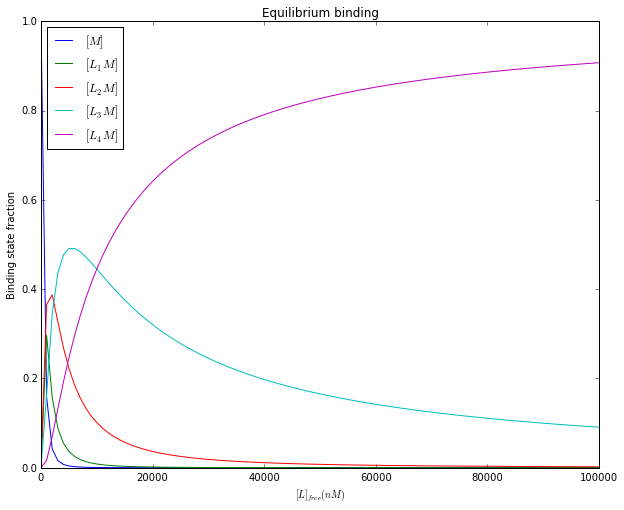

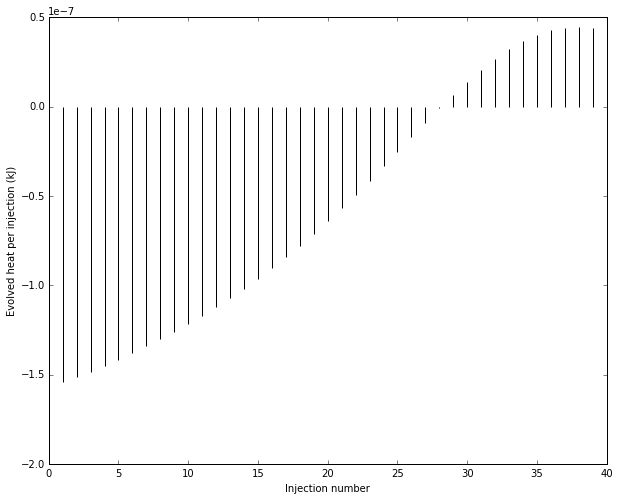

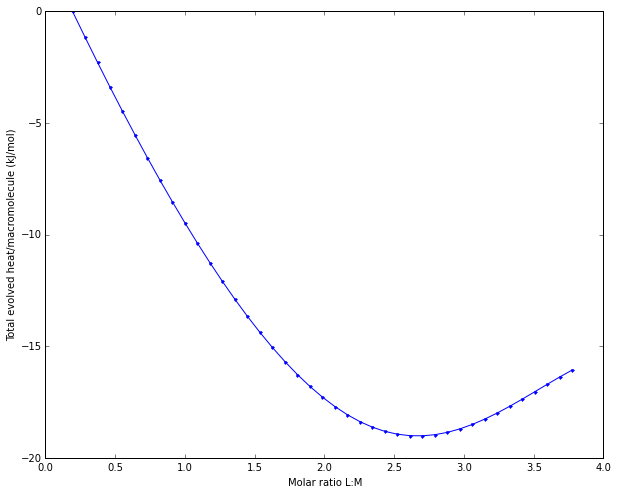

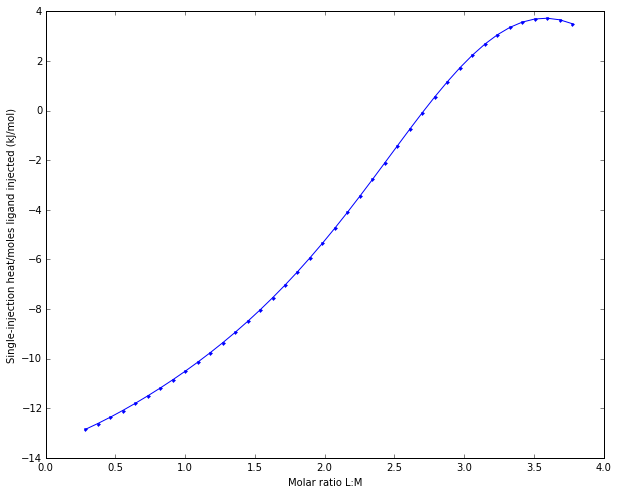

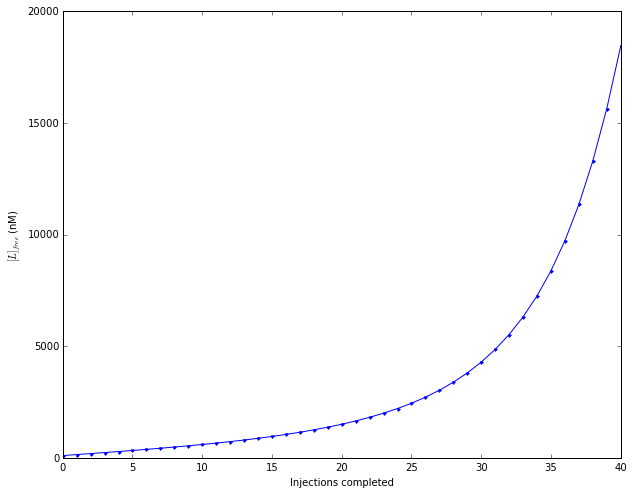

In [15]:
w = ipw.interactive(RunAndShowModel,
             Kd1_nM = skd1, Kd2_nM = skd2, Kd3_nM = skd3, Kd4_nM = skd4,
             dH1 = sdh1, dH2 = sdh2, dH3 = sdh3, dH4 = sdh4,
             M0_nM = sm0, Lfree0_nM = sl0, V0_uL = sv0,
             Vinjection_uL = svi, Linjection_nM = sli, ninjections = sni,
             Lfreemin_nM = slfmin, Lfreemax_nM = slfmax, npts = snlf)

display(w)